In [1]:
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np
import pickle
import json
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GRU, Input, Dropout, Bidirectional, MaxPooling1D, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import tensorflow as tf

from utils.utils import *

# Load Data

In [2]:
df_smiles = pd.read_csv('data/test/smiles_test.csv')
df_train = pd.read_csv('data/test/test.csv')

# Mol2Vec

In [4]:
smiles = df_smiles['Smiles']
featurizer = dc.feat.Mol2VecFingerprint()
features = featurizer.featurize(smiles)

Failed to featurize datapoint 8, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 10, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 14, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 32, None. Appending empty array


In [5]:
nan_idx = []
for idx, i in enumerate(features):
    if len(i)==0:
        nan_idx.append(idx)
print(len(nan_idx))

763


In [6]:
features[nan_idx] = np.NaN

In [7]:
pickle.dump(features, open('data/test/mol2vec.pkl', 'wb'))

# Preprocessing Features

In [241]:
df = pd.read_csv('data/train/train.csv')

features = pickle.load(open('data/train/mol2vec.pkl', 'rb'))
nan_idx = []
for idx, i in enumerate(features):
    if type(i) == np.float:
        nan_idx.append(idx)

X = features
y = df['CO2_working_capacity [mL/g]'].to_numpy()

X = np.delete(X, nan_idx)
y = np.delete(y, nan_idx)

expand_dim = lambda x:np.expand_dims(x, axis=0)
X = np.concatenate(list(map(expand_dim, X)), axis=0)

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [243]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# MLP

In [165]:
def create_model(dim):
    input_ = Input(shape=(dim, ))
    x = Dense(62, activation='relu')(input_)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
#     x = Dropout(0.3)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['mean_absolute_error'])  
    return model

In [166]:
model = create_model(X_train.shape[1])

In [ ]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=300, validation_data=(X_test, y_test), verbose=0)

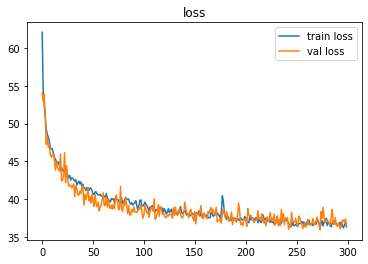

In [168]:
show_history(hist)

In [169]:
print("MAE: {}".format(hist.history['val_loss'][-1]))

MAE: 36.46905517578125


# XGBoost

In [244]:
n_estimators = 100
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=n_estimators)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("train MAE: {}".format(mae))

preds = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("val MAE: {}".format(mae))

train MAE: 29.52960223857495
val MAE: 43.82707038193265


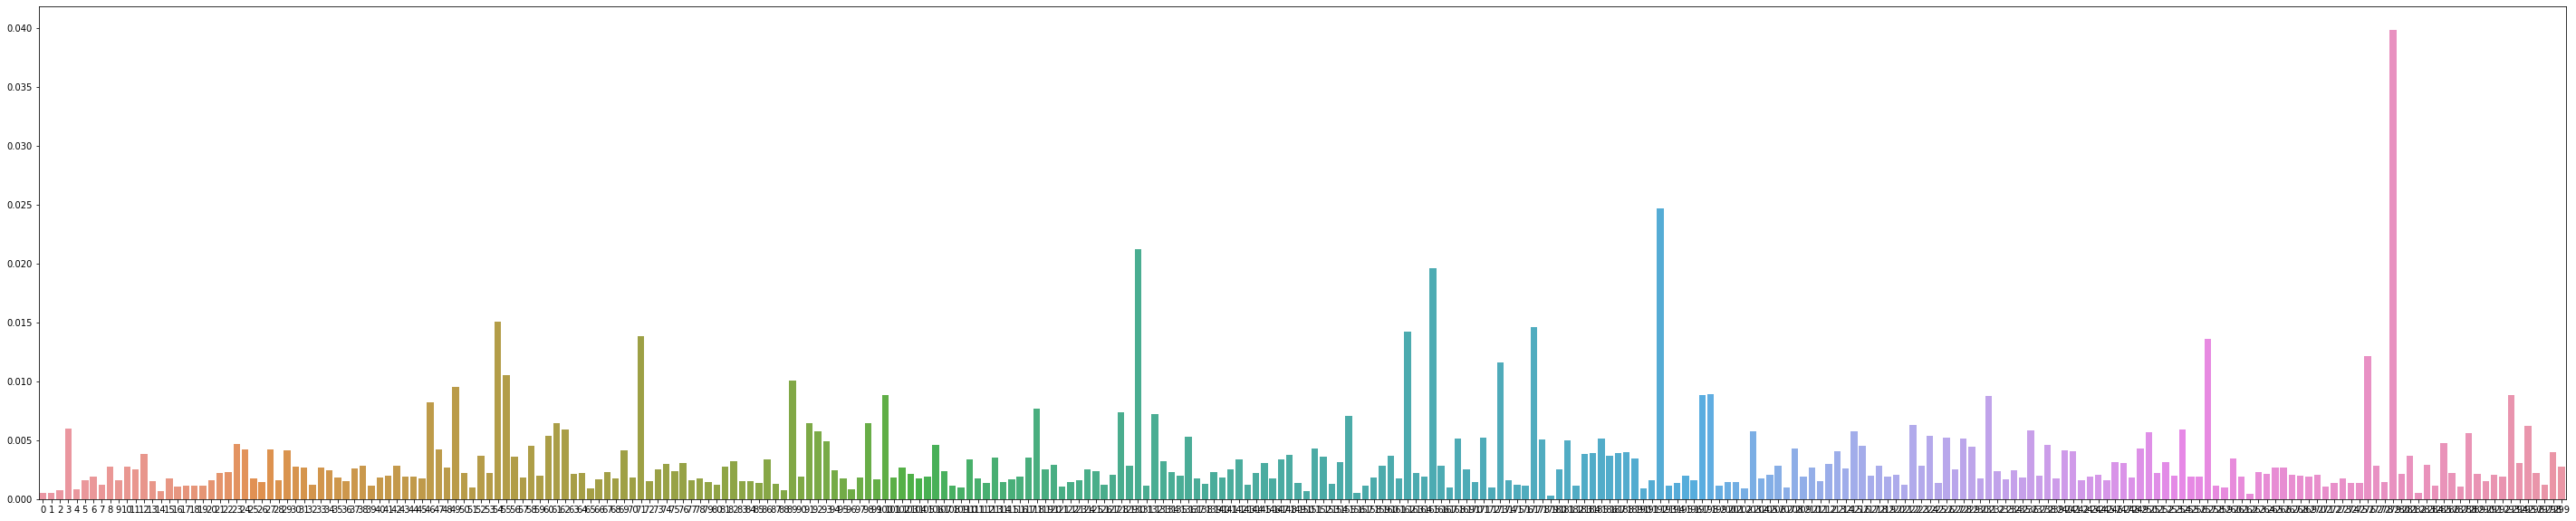

In [132]:
plt.figure(figsize=(50, 10))
sns.barplot(x=np.arange(300), y=xg_reg.feature_importances_)
plt.show()